In [1]:
import os

os.environ["HUGGINGFACE_HUB_CACHE"] = "/data/sshadmin/bocheng/.cache/huggingface/hub/"
from dataclasses import dataclass

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    # push_to_hub = True  # whether to upload the saved model to the HF Hub
    # hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    # hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(
    config.dataset_name,
    split="train",
    cache_dir="/data/sshadmin/bocheng/data/huggingface/data",
)

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


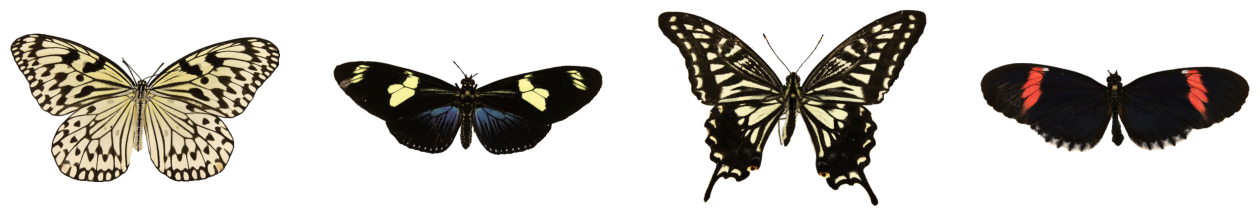

In [3]:
import matplotlib.pyplot as plt 
fig,axs=plt.subplots(1,4,figsize=(16,4))
for i,image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()    

In [4]:
from torchvision import transforms
preprocess=transforms.Compose(
    [
        transforms.Resize((config.image_size,config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

In [5]:
def transform(examples):
    images=[preprocess(image.convert("RGB")) for image in examples['image']]
    return {"images":images}

dataset.set_transform(transform)

In [6]:
import torch
train_dataloader=torch.utils.data.DataLoader(dataset,batch_size=config.train_batch_size,shuffle=True)

In [8]:
from diffusers import UNet2DModel

model=UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128,128,256,256,512,512),
    down_block_types=(
         "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [9]:
sample_image=dataset[0]['images'].unsqueeze(0)
print("Input shape:",sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [11]:
print("Output shape:",model(sample_image,timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


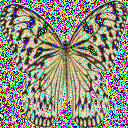

In [12]:
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
Image.fromarray(
    ((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0]
)

In [13]:
import torch.nn.functional as F
noise_pred=model(noisy_image,timesteps).sample 
loss=F.mse_loss(noise_pred,noise)

In [14]:
from diffusers.optimization import get_cosine_schedule_with_warmup
optimizer=torch.optim.AdamW(model.parameters(),lr=config.learning_rate)
lr_scheduler=get_cosine_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=config.lr_warmup_steps,num_training_steps=(len(train_dataloader)*config.num_epochs))

In [25]:
from diffusers import DDPMPipeline 
from diffusers.utils import make_image_grid
import os
def evaluate(config,epoch,pipeline):
    images=pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images
    image_grid=make_image_grid(images,rows=4,cols=4)
    test_dir=os.path.join(config.output_dir,"samples")
    os.makedirs(test_dir,exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [26]:
from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os


def train_loop(
    config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler
):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_examples")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(
            total=len(train_dataloader), disable=not accelerator.is_local_main_process
        )
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (bs,),
                device=clean_images.device,
                dtype=torch.int64,
            )
            noisy_images = noise_scheduler.add_noise(clean_images,noise,timesteps)
            with accelerator.accumulate(model):
                noise_pred=model(noisy_images,timesteps,return_dict=False)[0]
                loss=F.mse_loss(noise_pred,noise)
                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(),1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
    
        if accelerator.is_main_process:
            pipeline=DDPMPipeline(unet=accelerator.unwrap_model(model),scheduler=noise_scheduler)
            if (epoch+1)%config.save_image_epochs==0 or epoch==config.num_epochs-1:
                evaluate(config,epoch,pipeline)
            if (epoch+1)%config.save_model_epochs==0 or epoch==config.num_epochs-1:
                pipeline.save_pretrained(config.output_dir)
                
                
            
            
                
            

In [27]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
train_loop(*args)



Epoch 0: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s, loss=0.0174, lr=6.81e-5, step=62]






























































































































































































































































Epoch 1: 100%|██████████| 63/63 [00:18<00:00,  3.34it/s, loss=0.00605, lr=6.46e-5, step=125]


Epoch 2: 100%|██████████| 63/63 [00:18<00:00,  3.37it/s, loss=0.00175, lr=6.1e-5, step=188]






























































































































































































































































Epoch 3: 100%|██████████| 63/63 [00:18<00:00,  3.32it/s, loss=0.0157, lr=5.73e-5, step=251]


Epoch 4: 100%|██████████| 63/63 [00:18<00:00,  3.32it/s, loss=0.0166, lr=5.36e-5, step=314]




























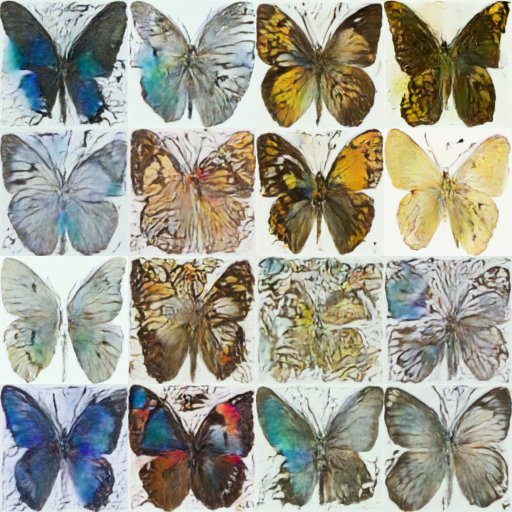

In [28]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])